# Calibrating machine-learning models to increase the prediction accuracy of specific experiments
### Aleš Křenek
#### Sitola, 22.9.2021

## Two-slide quick tour to LC/MS

## Importance of RT prediction
### Reference dataset
- Known compounds and measured retention time (clean, single compound sample) in our lab

### Experimental data
- Unknown compounds, list of candidates available from MS analysis -- too many
- Measured retention time
- The goal: by predicting the retention time, **shortlist the candidates**

In [ ]:
# just bookkeeping
featf='features.csv'
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd,chdir
from moldescriptors import get_features
from main import make_preds
datadir='/data'
prefix='/opt/callc/rt/'
modlib=prefix + 'mods_l1/'
models=['bayesianregr','lasso']
featn=[x.strip() for x in open(prefix+"features/selected_features.txt").readlines()]
featn.remove('system')
with open('feats_lib.csv','w'): pass

## Train a fresh model with our data

In [ ]:
from sklearn.linear_model import ARDRegression
from scipy.stats import randint
from scipy.stats import uniform
import random
random.seed(815)
model = ARDRegression()
params = {
        "n_iter" : randint(100,1500),
        "alpha_1" : uniform(1e-10,1e-2),
        "lambda_1" : uniform(1e-10,1e-2),
        "threshold_lambda" : randint(1,10000),
    }

## Formulae and features
SMILES (Simplified Molecular Input Line Entry System) format: CN1CCCC1C2=CN=CC=C2
<img src="nikotine.png" style="width: 25vw;"/>

In [129]:
get_features(infile_name='nikotine.tsv',outfile_name=featf,id_index=0,mol_index=1,time_index=2)
pd.read_csv(featf)

,IDENTIFIER,time,MinPartialCharge,SlogP_VSA2,MaxAbsPartialCharge,SMR_VSA9,NumAliphaticHeterocycles,fr_ether,Kappa2,fr_azide,...,NumHAcceptors,fr_benzodiazepine,MinEStateIndex,fr_ketone_Topliss,fr_C_O_noCOO,fr_HOCCN,SMR_VSA4,PEOE_VSA7,fr_sulfide,NumRotatableBonds
0,nikotine,1234,-0.299307,23.476317,0.299307,0.0,1,0,3.232934,0,...,2,0,0.609907,0,0,0,0.0,38.06389,0,1


### Train the model on our reference dataset

In [130]:
get_features(infile_name='train_positive.tsv',outfile_name=featf,id_index=3,mol_index=0,time_index=2)
features = pd.read_csv(featf)[featn]
features.shape

(175, 159)

In [131]:
from random import shuffle
testsize=int(len(features.index)*.2)
index=list(range(len(features.index)))
shuffle(index)
test=features.iloc[index[:testsize]]
train=features.iloc[index[testsize:]]

In [157]:
from sklearn.model_selection import KFold
from trainl1 import train_model_l1
cv = list(KFold(n_splits=10,shuffle=True).split(train.index))
model,train_preds = train_model_l1(train.drop(["time","IDENTIFIER","system"],axis=1, errors="ignore"),
                                             train["time"],params,model,
                                             cv = cv,n_params=20,
                                             n_jobs=4)

In [158]:
def rtscatter(rt,mod):
    plt.figure(figsize=(8,6))
    plt.plot([200,1200],[200,1200],color='grey')
    plt.scatter(rt,mod)
    plt.show()

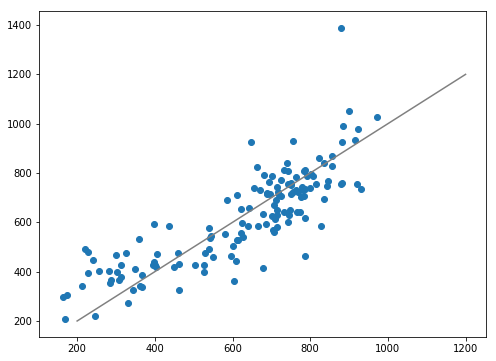

In [159]:
rtscatter(train['time'],train_preds

### Apply on independent test set

In [138]:
test_preds = model.predict(test.drop(["time","IDENTIFIER"],axis=1))

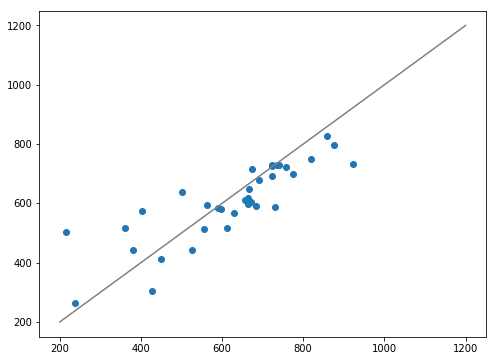

In [160]:
rtscatter(test['time'],test_preds)

### How good is the model?
* Plot the graph and assess intuitively -- "chi by eye"
* ... or do something more exact -- _goodness of fit_
* Total sum of squares
$$ SS_{tot}=\sum (y_i - \bar y)^2 $$
* Resitual sum of squares 
$$ SS_{res} = \sum (y_i - M(x_i))^2 $$
* _Coeffitient of determination_
$$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$
* Intuitively: How much variance in the data the model explains?
  * $R^2 = 1$ -- the model is perfect
  * $R^2 = 0$ -- the model is not better than expecting average value of $y$
  * $R^2 < 0$ or $R^2 > 1$ -- the model is even worse than expecting the average

In [140]:
def r2(measured,model):
    mean = np.average(measured)
    yres = measured-mean
    modres = model-measured
    ss_tot = np.sum(yres*yres)
    ss_res = np.sum(modres*modres)
    return 1. - ss_res/ss_tot

In [142]:
r2(np.array(test['time']),test_preds)

0.6918880248670789

- Not entirely bad (the model works, somehow)
- Not overimpressive either
- Rather meaningless in [0.5,1.0] as absolute value, good for assessing improvements

## Apply available models on our data
- Someone else more lucky (more rich) could have measured bigger datasets
- We can try reusing their models

In [143]:
def apply_model(X,modname):
    modf=modlib + modname + '42.pickle'
    with open(modf,"rb") as m:
        model = pickle.load(m,encoding='latin1')
    preds=model.predict(X)
    return preds

In [144]:
dataset='MTBLS20'
preds={}
for m in models:
    preds[m] = apply_model(features.drop(['IDENTIFIER','time'],axis=1),modname=dataset+'_'+m)

/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator ARDRegression from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Lasso from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


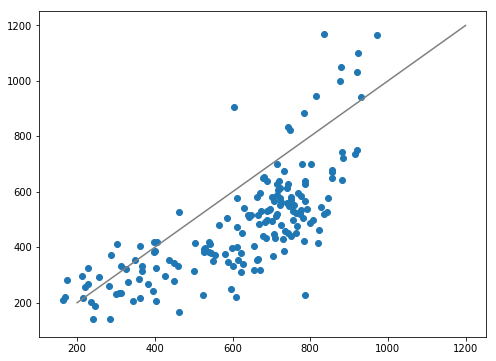

In [161]:
bayes_good=(preds['bayesianregr'] < 1200) # get rid of apparent outliers
rtscatter(np.array(features['time'])[bayes_good],preds['bayesianregr'][bayes_good])

In [163]:
r2(np.array(features['time'])[bayes_good],preds['bayesianregr'][bayes_good])

0.003468672867390832

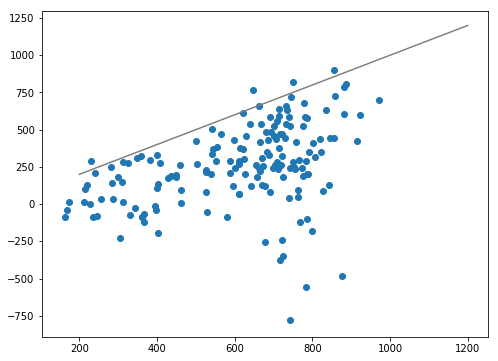

In [164]:
lasso_good=(np.abs(preds['lasso']) < 1000)
rtscatter(np.array(features['time'])[lasso_good],preds['lasso'][lasso_good])

In [165]:
r2(np.array(features['time'])[lasso_good],preds['lasso'][lasso_good])

-4.261710291660824

## CALLC main ideas
- *Callibrated All Liquid Chromatography* 
- Gather $N$ existing datasets: known compounds and RT for a specific laboratory setup
- Train $M$ ML models on them independently, yielding $M\times N$ models altogether
- Measure a representative small *callibration* dataset in your lab
- Train the same ML models on the callibration dataset
- Apply all $M\times (N+1)$ models callibration dataset
- Find the best *GAM (generalized additive model)* curves to transform the models outputs
- Pick the right set of models and their linear combination with *elastic net*

## Employ the big beast

In [ ]:
chdir(datadir)
train.to_csv('reference.csv')
test.to_csv('test.csv')
chdir(prefix)
make_preds(reference_infile=datadir + '/reference.csv',pred_infile=datadir + '/test.csv',
           outfile=datadir+'/test_preds')

In [ ]:
chdir(datadir)
big_pred=pd.read_csv('test_preds.csv')

In [ ]:
plt.figure(figsize=(10,8))
plt.plot([200,1000],[200,1000],label='diagonal',color='grey')
plt.scatter(test['time'],big_pred['predictions'],label='full model')
plt.scatter(test['time'],test_preds,label='in house only')
plt.legend()
plt.show()

In [ ]:
r2(np.array(test['time']),np.array(test_preds['predictions']))

In [ ]:
r2(np.array(test['time']),big_pred['predictions'])